<a href="https://colab.research.google.com/github/ThiagoPoppe/snare_rythm_transcription/blob/main/snare_rythm_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalando dependências para o projeto
!pip install git+https://github.com/ThiagoPoppe/snare_rythm_transcription.git

  Cloning https://github.com/ThiagoPoppe/snare_rythm_transcription.git to /tmp/pip-req-build-t7skemq2
  Running command git clone -q https://github.com/ThiagoPoppe/snare_rythm_transcription.git /tmp/pip-req-build-t7skemq2
  Created wheel for snare-rythm-transcription: filename=snare_rythm_transcription-0.1-py3-none-any.whl size=2633 sha256=6af8936105d2485451662b15ceff63969239249c3249cb8027e2af0e01023742
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3m5oeo8/wheels/5f/61/77/1d6786fe6d5970ccc00d94354f82d1cacd18758b00c6dbc30e
Successfully built snare-rythm-transcription


# Configuração do ambiente (instalação de outras dependências)

In [3]:
import os
from music21.environment import UserSettings

# Musescore permite com que a gente renderize imagens com as notas musicas do music21
print('installing musescore...')
!apt-get install musescore > /dev/null

# FluidSynth será utilizado para converter midi para .wav (apenas para escutarmos)
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Configurações do virtual framebuffer (necessário para o Google Colab)
!apt-get install xvfb > /dev/null
!sh -e /etc/init.d/x11-common start > /dev/null

os.putenv('DISPLAY', ':99.0')
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

# Configurando o path do music21
us = UserSettings()
us['directoryScratch'] = '/tmp'
us['musicxmlPath'] = '/usr/bin/mscore'
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'

print('done!')

installing musescore...
Extracting templates from packages: 100%
installing fluidsynth...
done!


# Unzip dos dados
- Para esse passo, certifique-se que você já incluiu o arquivo `archive.zip` do seguinte [link](https://drive.google.com/file/d/1UlRr061Fiy9kgxMSP_-9QqWN_RirAC7g/view?usp=sharing).

In [4]:
# Você pode realizar um mount do seu drive e dar unzip no arquivo
!unzip /content/drive/MyDrive/MIR/snare_rythm_transcription/archive.zip -d /content/ > /dev/null

# Funções auxiliares de exibição

In [20]:
import copy
import IPython.display as ipd
from midi2audio import FluidSynth

from music21.note import Note
from music21.stream import Stream
from music21.clef import PercussionClef
from music21.tempo import MetronomeMark
from music21.meter import TimeSignature

def snare_hit(midi=38, length=1.0):
    """
        Método auxiliar para criarmos um toque na caixa.

        Argumentos:
            - midi (int): valor em MIDI da "nota" (default = 38)
            - length (float): figura de tempo da nota, utilizando a semínima como referência (default = 1.0)

        Retorno:
            - Esse método retorna um Note do music21 representando um toque na caixa
    """
    return Note(midi, quarterLength=length)

def create_percussive_stream(bpm=60, time_signature='4/4'):
    """
        Método auxiliar para criarmos um stream percussivo.

        Argumentos:
            - bpm (int): BPM da música (default = 60)
            - time_signature (str): fórmula de compasso da música (default = '4/4')

        Retorno:
            - Um Stream com o BPM e TimeSignature informados.
    """
    stream = Stream()
    stream.insert(0, PercussionClef())
    stream.insert(0, MetronomeMark(number=bpm))
    stream.insert(0, TimeSignature(time_signature))

    return stream


def show(stream):
    """
        Método para exibir a partitura da música.

        Infelizmente o music21 ainda não suporta muitas features de instrumentos percussivos.
        Para isso, iremos modificar a nota apenas para a sua exibição correta.
        Por exemplo, um toque na caixa está na posição da nota B4 na partitura.

        Argumentos:
            - stream (Stream): música a ser exibida

        Retorno:
            - None

        Observações:
            - Infelizmente o music21 ainda não suporta muitas features de instrumentos percussivos.
              Para isso, iremos modificar a nota apenas para a sua exibição correta.
              Por exemplo, um toque na caixa está na posição da nota B4 na partitura.
    """
    stream_cp = copy.deepcopy(stream)
    for note in stream_cp.recurse().notes:
        note.name = 'B4' # toques na caixa correspondem à posição do B4
        note.stemDirection = 'up'

    stream_cp.show()

def play(stream, wavname='music.wav', sound_font='pns_drum_kit.SF2'):
    """
        Método para tocarmos a música.

        Argumentos:
            - stream (Stream): música a ser exibida
            - wavname: nome do .wav a ser gerado (default = 'music.wav')
            - sound_font: sound font a ser utilizado (default = 'pns_drum_kit.SF2')

        Retorno:
            - None

        Observações:
            - Como estamos trabalhando exclusivamente com percussão, utilizaremos
              por padrão um SoundFont de bateria.
    """
    if not os.path.exists(sound_font):
        raise ValueError(f'[warning] sound font {sound_font} not found')

    midi_file = stream.write('midi')
    fs = FluidSynth(sound_font=sound_font)
    fs.midi_to_audio(midi_file, wavname)
    ipd.display(ipd.Audio(wavname))

# Exemplo para vermos se está tudo funcional
- Para esse exemplo você deveria ser capaz de observar uma partitura de percussão (iniciada com duas barrinhas), com fórmula de compasso 4/4 e BPM = 80. Além disso, deveria ser capaz de ver 6 notas, sendo elas 1 tercina (triplet) e 3 semínimas.

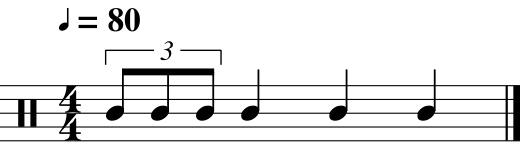

In [23]:
from music21.stream import Stream

stream = create_percussive_stream(bpm=80)
stream.repeatAppend(snare_hit(length=1/3), 3)
stream.repeatAppend(snare_hit(), 3)

play(stream)
show(stream)